# AI Learning Day: Explainable Artifical Intelligence (XAI) Hands-on Lab

___

**Introduction**

Machine learning (ML) systems are increasingly being integrated across various industries. Applications range from autonomous vehicle technology in self-driving cars to the development of sophisticated virtual assistants for improved user interactions. This widespread use of ML in complex applications has sparked a surge in the interest of developing systems that are optimized not just for performance, but also for other crucial factors like safety, non-discrimination, and reliability. However, unlike straightforward performance metrics such as accuracy, these additional criteria are often challenging to quantify. For instance, it's difficult to list all necessary safety checks for a semi-autonomous vehicle or to fully ensure a credit scoring system is free from bias. In these scenarios, the criterion of interpretability becomes key. If an ML system can explain its reasoning, we can then assess whether its logic aligns with these essential standards.

This broad adoption of ML technologies underscores the importance of **Eplainable AI (XAI)**, which aims to make the complex decision-making processes of these systems transparent and understandable, ensuring their reliability and trustworthiness in critical applications. New laws and data protection rules, like the European General Data Protection Regulation (GDPR) that started in May 2018, require more transparency in how data is used, making it challenging to implement systems that don't easily show how decisions are made.


**Goals**

In this lab, we train a machine learning model on the [Diabetes dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) to predict whether a patient has diabetes based on diagnostic measurements and delve into explainable AI techniques. We'll explore both model-specific approaches, which are tailored to the specific type of machine learning model we're using, and model-agnostic approaches, which can be applied regardless of the model type. 



*Model Agnostic approaches:*
- SHAP
- LIME

*Model specific approaches:*
- DeepLIFT
- Layer-Wise Relevance Propagation (LRP)
- Integrated gradiens

(ADD PICTURE THAT SHOWS TRADEOFF BETWEEN COMPLEXITY AND EXPLAINABILITY)

(Make graph of number of stars in this paper)


In [27]:
! jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


# Part 1: Train a model

## 1. Read dataset

The Diabetes dataset from comprises diagnostic measurements related to diabetes in a sample of women, including glucose concentration, blood pressure, and BMI, among others. The target variable 'Outcome' 0 indicates no diabetes, and 1 signifies the presence of diabetes.The Diabetes dataset from Kaggle features diagnostic measurements for predicting diabetes, including glucose levels and BMI. The target variable, often labeled as "Outcome," uses 0 to indicate no diabetes and 1 for its presence.

In [3]:
import pandas as pd

#TODO: FIX RELATIVE PATH
diabetes_data = pd.read_csv('../data/diabetes.csv')
display(diabetes_data.head())
print(f"Shape of dataframe: {diabetes_data.shape}")


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Shape of dataframe: (768, 9)


## 2. Data Processing

Note: choose dataset that requires minimal data preprocessing, so we can minimize data preparation from the list as that is not the focus of the lab.



### 2.1 Exploratory Data Analysis


[ADD EXPLANATION AND INTERPRETATION ABOUT PLOTS HERE]

Check for missing values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


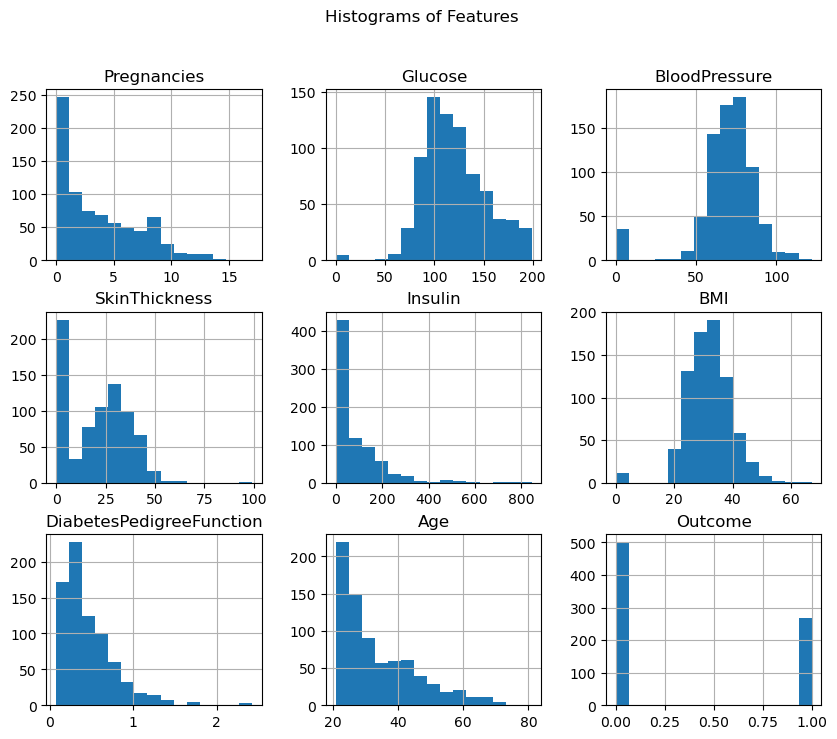

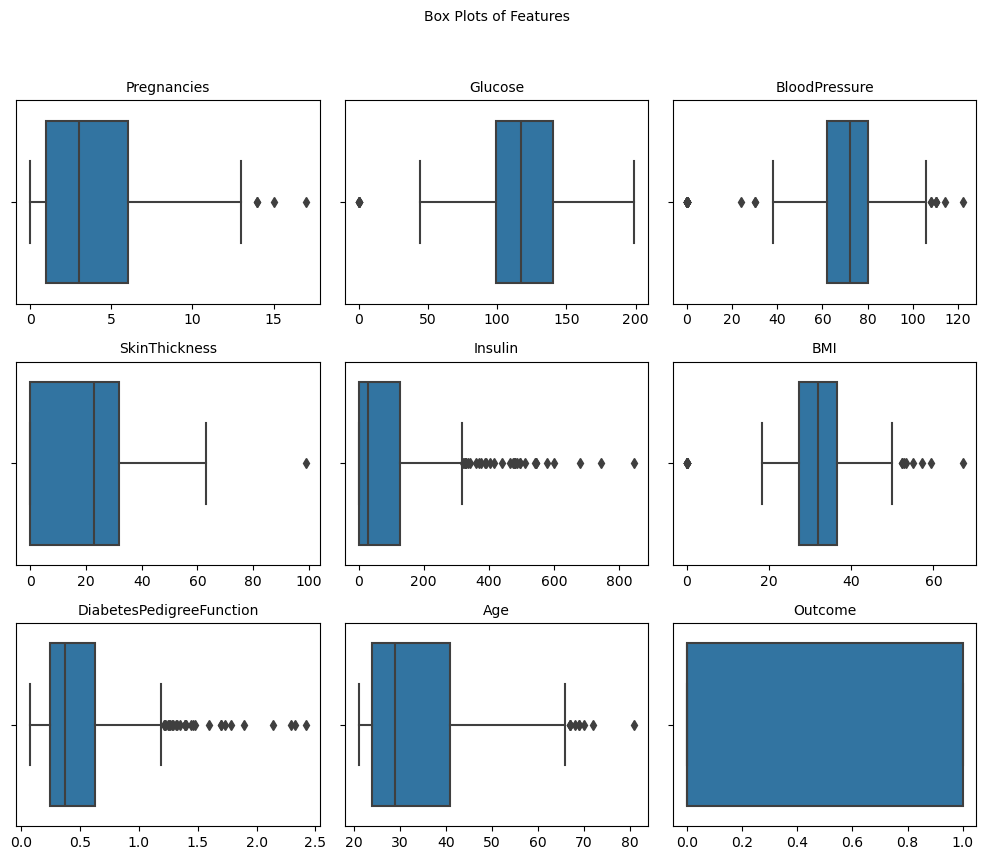

In [17]:
import scripts.eda_utils as eda

# TODO: ALIGN FIGURES BETTER

print(f"Check for missing values:")
print(diabetes_data.isnull().sum())

eda.plot_histograms(diabetes_data)
eda.plot_boxplots(diabetes_data)
# eda.plot_correlation_heatmap(diabetes_data)

In [24]:
### ASSIGNMENT 1 ###

# WHICH OF THE FEATURES ARE PROBABLY MOST CORRELATED WITH THE TARGET VARIABLE?

### 2.2 Data Preprocessing

#### Preprocessing

- Ensure all missing values are imputed: there are no missing values. 
- Normalize or standardize the features to have a similar scale, which is crucial for neural network training. (Although not neccesary for random forest)
- Encode categorical variables as necessary, using techniques like One-Hot Encoding.
- Check target distribution


In [ ]:
## ONLY FOR NN
## Todo: Create two seperate preprocessing pipelines, one for NN and one for RF.

from sklearn.preprocessing import StandardScaler

# Define features and target
X = diabetes_data.drop('Outcome', axis=1)  # Assuming 'Outcome' is the target variable
y = diabetes_data['Outcome']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#### Split the dataset

In [19]:
from sklearn.model_selection import train_test_split

# Drop target column from dataset
X = diabetes_data.drop(columns=['Outcome'], axis=1)
# Isolate target to seperate dataset
y = diabetes_data['Outcome']

# Split the data into training and test set.
# The test size specifies that 20% of the data will be used for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## 3. Train Model

In this section we train two different models. The first model is a **Random Forest** and the second is a **Feedforward Neural Network**.

Tree-based models like Random Forests are inherently more explainable due to their decision-making process, which mimics human decision-making by splitting data based on feature values. In contrast, deep learning models, due to their complex network of layers and non-linear transformations, lack this intuitive explainability, making it challenging to understand how they arrive at specific predictions.

### 3.1 Random Forest

A random forest is a machine learning model that combines multiple decision trees to improve prediction accuracy, but with many trees the model becomes more complicated and it becomes difficult to trace back through the many paths to understand the rationale behind its decisions.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics

random_forest_classifier = RandomForestClassifier(random_state=80)
random_forest_classifier.fit(X_train.values, y_train.values)

# Make prediction on the testing data
y_pred = random_forest_classifier.predict(X_test.values)

# Get performance metrics
print(metrics.classification_report(y_pred, y_test))
print(f"Model Accuracy: {metrics.accuracy_score(y_pred, y_test):.3f} \n")


              precision    recall  f1-score   support

           0       0.81      0.80      0.80       100
           1       0.64      0.65      0.64        54

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

Model Accuracy: 0.747 



### 3.2 Neural Network


https://www.learnpytorch.io/02_pytorch_classification/
https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/

In [21]:

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    torch.manual_seed(seed_value)  # PyTorch
    torch.cuda.manual_seed_all(seed_value)  # for multi-GPU
    np.random.seed(seed_value)  # NumPy
    random.seed(seed_value)  # Python
    torch.backends.cudnn.deterministic = True  # For CUDA backend, making computations deterministic

# Call the function with your desired seed
set_seed(42)


In [22]:
class NNClassifier(nn.Module):
    def __init__(self):
        super(NNClassifier, self).__init__()
        # Define the layers of the network
        self.hidden1 = nn.Linear(8, 12)  # First hidden layer
        self.hidden2 = nn.Linear(12, 8)  # Second hidden layer
        self.output = nn.Linear(8, 1)    # Output layer

    def forward(self, x):
        # Forward pass through the network with activation functions applied directly
        x = F.relu(self.hidden1(x))  # Apply ReLU activation function after first hidden layer
        x = F.relu(self.hidden2(x))  # Apply ReLU activation function after second hidden layer
        x = torch.sigmoid(self.output(x))  # Apply Sigmoid activation function after output layer
        return x


In [23]:
model = NNClassifier()

# Loss function
loss_fn = nn.BCELoss()  # binary cross entropy

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 200  

for epoch in range(num_epochs):
    model.train()  
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = loss_fn(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval() 
with torch.no_grad():
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        # Convert probabilities to binary predictions
        predicted = (outputs.data > 0.5).float()  
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')


Epoch [5/200], Loss: 0.9654
Epoch [10/200], Loss: 0.4167
Epoch [15/200], Loss: 0.5798
Epoch [20/200], Loss: 0.6348
Epoch [25/200], Loss: 0.5654
Epoch [30/200], Loss: 0.6763
Epoch [35/200], Loss: 0.4878
Epoch [40/200], Loss: 0.7379
Epoch [45/200], Loss: 0.5563
Epoch [50/200], Loss: 0.6497
Epoch [55/200], Loss: 0.4537
Epoch [60/200], Loss: 0.2936
Epoch [65/200], Loss: 0.4633
Epoch [70/200], Loss: 0.5536
Epoch [75/200], Loss: 0.6139
Epoch [80/200], Loss: 0.2221
Epoch [85/200], Loss: 0.4791
Epoch [90/200], Loss: 0.5439
Epoch [95/200], Loss: 0.2358
Epoch [100/200], Loss: 0.4656
Epoch [105/200], Loss: 0.6165
Epoch [110/200], Loss: 0.5240
Epoch [115/200], Loss: 0.4603
Epoch [120/200], Loss: 0.4992
Epoch [125/200], Loss: 0.3499
Epoch [130/200], Loss: 0.7085
Epoch [135/200], Loss: 0.6131
Epoch [140/200], Loss: 0.4791
Epoch [145/200], Loss: 0.5531
Epoch [150/200], Loss: 0.6626
Epoch [155/200], Loss: 0.2004
Epoch [160/200], Loss: 0.7085
Epoch [165/200], Loss: 0.5127
Epoch [170/200], Loss: 0.4659


# Part 2: Get explanations from model

## 5. Model Agnostic


Model-agnostic methods for explaining AI can work with any type of machine learning model, unlike model-specific methods that are designed to explain only a specific type of model. LIME and SHAP are two popular libraries that help us understand how different machine learning models make their decisions. 

- https://www.geeksforgeeks.org/introduction-to-explainable-aixai-using-lime/
- https://github.com/marcotcr/lime?tab=readme-ov-file

### 5.1 LIME (Local Interpretable Model-agnostic Explanations)
LIME  is a technique that explains individual predictions of any classifier by approximating it locally with an interpretable model. It works by perturbing the input data and observing how the predictions change, helping to identify which features significantly influence the output. LIME provides simple explanations that can help users understand why a model made a particular decision for a specific instance.

(INSERT IMAGE OF LIME HERE)

LIME makes complex models easier to understand by focusing on one data point at a time. Think of the model as a complicated landscape with hills and valleys. LIME looks closely at the flat ground around one point (let's call it "X") to understand how the model decides things just there. It's like drawing a simple, straight line on the ground around "X" to represent the model's decision-making process nearby, without worrying about the whole landscape. This line helps us see why the model made its decision for "X," using a simpler explanation that ignores the complex parts far away from "X."



works on all models that has .predict_proba



In [ ]:
import lime
from lime import lime_tabular
import numpy as np
import warnings

%matplotlib inline

# Suppress FutureWarning
warnings.filterwarnings(action='ignore', category=FutureWarning, module='lime')


explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['no_diabetes', 'diabetes'],
    mode='classification',
    random_state=80
)

In [ ]:
def explain_instance_with_lime(data_row_index: int, num_features: int) -> None:
    # Ensure explainer is previously defined and the model is trained
    exp = explainer.explain_instance(
        data_row=X_test.iloc[data_row_index], 
        predict_fn=random_forest_classifier.predict_proba,  # Prediction function from the trained model
        num_features=num_features  # Number of features to consider for the explanation
    )
    
    # Display the explanation in the notebook
    exp.show_in_notebook(show_table=True)

# Example usage:
explain_instance_with_lime(data_row_index=5, num_features=5)


Interpretation:
- The model is 65% confident that this perrson has diabetes
- The values of age, BMI and insulin increases this person's chance to be classified as diabetic
- While the values of glucose and bloodpressure decreases it

In [ ]:
# Inspect and analyze another instance here

#### Advantages and disadvantages

As a limitation can be seen that LIME only indirectly solves the explanation problem by relying on a surrogate model. Thus, the quality of the explanation largely depends on the quality of the surrogate fit, which itself may require dense sampling and thus may result in large computational costs.Furthermore, sampling always introduces uncertainty, which can lead to nondeterministic behaviours and result in variable explanations for the same input sample.

### 5.2 SHAP (SHapley Additive exPlanations) 

- https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

[SHAP](https://pypi.org/project/shap/) is a method that assigns each feature an importance value for a particular prediction. It is based on the concept of Shapley values from cooperative game theory, considering all possible combinations of features to determine the contribution of each feature to the prediction. SHAP values offer a consistent and fair way to distribute the "payout" (prediction) among the features, providing a detailed insight into how each feature impacts the model's decision.

SHAP works as follows:

- Baseline Prediction: Start with the baseline prediction, which is the average prediction for all data points (explain this better). This serves as the starting point for understanding feature contributions.

- Feature Attribution: Add features one by one and observe how the prediction changes. It's essential to consider all possible feature orders and take their averages to ensure robustness.

- SHAP Values: Calculate the SHAP value for each feature. The SHAP value represents the contribution of a feature to the prediction. It's the difference between the prediction with the feature and the prediction without the feature. Positive values indicate features that increase the prediction, while negative values indicate features that decrease it.

- Sum of SHAP Values: The sum of all SHAP values should equal the difference between the prediction for a specific data point and the average prediction for all data points. This ensures that all feature contributions are properly accounted for.


SHAP offers different kind of plots:

- **Summary Plot**: Provides a global overview of feature importance and their impacts on model predictions.
- **Dependence Plot**: Illustrates the relationship between a single feature's value and its effect on model predictions, highlighting potential feature interactions.
- **Force Plot**: Visualizes the contribution of each feature to an individual prediction, emphasizing the push-and-pull dynamic among features.
- **Decision Plot**: Traces the cumulative impact of features on the model's output, revealing the sequential contribution towards the final prediction.

In [26]:
import shap

explainer = shap.TreeExplainer(random_forest_classifier)
shap_values = explainer.shap_values(X_test)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


The summary plot shows the feature importance of each feature in the model. The results show that “Glucose,” “Age,” and “BMI” are the most important features.

In [25]:
shap.summary_plot(shap_values, X_test)


NameError: name 'shap' is not defined

In [ ]:
# Display summary plot of 0
shap.summary_plot(shap_values[0], X_test)

In [ ]:
# Check what goes wrong here
shap.dependence_plot("Glucose", shap_values[0], X_test,interaction_index="BMI")

In [ ]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0, :])

In [ ]:
shap.plots.force(explainer.expected_value[1], shap_values[1][6, :], X_test.iloc[6, :])

https://towardsdatascience.com/introducing-shap-decision-plots-52ed3b4a1cba

In [ ]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.columns)

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[0], X_test.columns)

In [ ]:
def explain_instance_with_shap(data_row_index: int) -> None:
    shap_values = explainer.shap_values(X_test.iloc[data_row_index])
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[data_row_index]))
    

explain_instance_with_shap(data_row_index = 5)

A force plot shows the impact of each feature on a single prediction of a machine learning model. The plot consists of three main components:

- The base value, which is the average prediction for all data points.
- The output value, which is the prediction for the specific data point. 
- The features, which are the input variables that influence the prediction. The length and color of the arrows indicate the magnitude and direction of the impact of each feature on the prediction. Red arrows increase the prediction, while blue arrows decrease it. The features are ordered by their importance.

Interpretation:
- The base value is 0.3452
- The model predicted 0.65 (diabetes)
- Biggest effect is age, then BMI, then Insulinb


## Model-specific methods

Different technics such as DeepLIFT, Grad-CAM, or Integrated Gradients can be leveraged to explain deep-learning models.


https://towardsdatascience.com/explainable-neural-networks-recent-advancements-part-4-73cacc910fef

### 6.1 Integrated gradients

https://pytorch.org/tutorials/beginner/introyt/captumyt.html


1. **Baseline Selection**: A baseline \(x'\) is chosen to represent a neutral state for all features, typically a vector of zeros, mean, or median values of the features.

2. **Path Interpolation**: The method constructs a path from the baseline \(x'\) to the actual input data point \(x\) through a series of small, linear steps. This is done by interpolating between \(x'\) and \(x\).

3. **Gradient Calculation**: At each interpolated point along the path, the gradient of the model's output with respect to the input features is calculated. This shows how sensitive the model's prediction is to changes in each feature.

4. **Integration of Gradients**: The gradients calculated at each step are integrated (typically averaged) to determine the overall contribution of each feature to the model's prediction.

5. **Attribution**: The integrated gradients provide a score for each feature, indicating its importance in the model's decision-making process.

The mathematical formulation for calculating the integrated gradients for a feature \(j\) is given by:

$$
\text{IG}_j = \frac{1}{n} \sum_{i=1}^{n} \frac{\partial f(x_i)}{\partial x_j} \times (x_j - x'_j)
$$

Where:
- $ \text{IG}_j $ is the integrated gradient for feature $j$,
- $ n $ is the number of steps in the path interpolation,
- $ \frac{\partial f(x_i)}{\partial x_j} $ is the gradient of the model's output with respect to feature $j$ at the $i$-th interpolated input,
- $ x_j - x'_j $ is the difference in feature $j$ between the actual input $x$ and the baseline $x'$.


### 6.2 DeepLIFT (Deep Learning Important FeaTures)

DeepLIFT (Deep Learning Important FeaTures) is an interpretability method designed to explain the predictions of deep neural networks by attributing contribution scores to individual input features. Unlike methods that rely on gradients, DeepLIFT compares the activation of each neuron to a reference activation and assigns contribution scores based on the difference, effectively capturing the effect of each input feature on the final prediction. This approach allows DeepLIFT to handle both linear and non-linear interactions within the network, providing a more detailed and nuanced understanding of how input features influence the model's output, especially in complex models where gradients may not provide sufficient insight into the decision-making process.


### 6.3 Layer-wise Relevance Propagation

Layer-Wise Relevance Propagation (LRP) is a technique used to explain the predictions of deep neural networks by backpropagating the prediction output back to the input layer, assigning relevance scores to individual input features that quantify their contribution to the final decision. LRP operates by conserving the relevance scores across layers, ensuring that the total relevance in the output layer is distributed back through the network down to the input features, adhering to the conservation principle. This method allows for a detailed decomposition of the model's decision, highlighting which features and their interactions were most influential, making it particularly useful for understanding complex models and their decisions on a granular level.

### 6.4 Activation Maximization -> MOVE TO CNN PART

Start with simpler models and then how it is appliclable in more complicated networks:
- Computer vision saliency maps
- LLM with attention 



**Additional Resources:**
- [Explainable AI Methods - A Brief Overview](https://link.springer.com/content/pdf/10.1007/978-3-031-04083-2_2.pdf)

